In [20]:
import os
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, random_split

from mllib.pytorch.files import save_results_as_csv
from mllib.pytorch.plot import save_plot_results
from mllib.pytorch.train import train
from mllib.utils.dvc import load_params
from mllib.utils.io import make_folder
from mllib.utils.logs import get_logger
from mllib.utils.pkl import save_data_as_pkl
from src.train.dataset import MelDataset
from src.train.models import get_grscl_transfrom, get_torch_model
from src.utils.files import get_label_dict

params = load_params()
logger = get_logger("TRAIN", log_level=params["base"]["log_level"])

zip_path = Path(params["data"]["train_zip"])
train_path = Path(params["data"]["processed_train_dir"])
model_path = Path(params["train"]["model"])
n_images = params["train"]["number_images"]

resluts_path_csv = Path(params["results"]["train_results_csv"])
resluts_path_png = Path(params["results"]["train_results_png"])
device = "cuda" if torch.cuda.is_available() else "cpu"

image_transform = get_grscl_transfrom()

label_dict = get_label_dict(zip_path=zip_path, prefix="", postfix=".png")
train_dataset = MelDataset(
    target_dir=train_path, labels_dict=label_dict, transform=image_transform
)
# train_dataset = datasets.ImageFolder(
#     root=train_path, transform=image_transform, target_transform=None
# )
# size dimension is not how it is expected
if n_images:
    train_dataset = Subset(train_dataset, torch.arange(0, n_images))
    logger.info("Number images to process {}".format(n_images))

# Split data

train_data, test_data = random_split(
    train_dataset,
    lengths=[0.8, 0.2],
    generator=torch.Generator().manual_seed(params["base"]["seed"]),
)

logger.info(
    "Train data size {}, test data size {}".format(len(train_data), len(test_data))
)

# Create DataLoaders
train_dataloader = DataLoader(
    dataset=train_data, batch_size=24, shuffle=True, num_workers=0
)
test_dataloader = DataLoader(
    dataset=test_data, batch_size=24, shuffle=12, num_workers=0
)
lr = params["train"]["lr"]
epochs = params["train"]["epochs"]

model = get_torch_model(params=params, device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
len(train_data), len(test_data)

2024-05-03 20:53:04,843 — TRAIN — INFO — Train data size 11149, test data size 2787


(11149, 2787)

In [ ]:
logger.info("TRAIN STARTS ...")
results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=epochs,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
)
logger.info("TRAIN COMPLEATES.")

logger.info("Current directory {}".format(os.getcwd()))
make_folder(model_path.parent)
save_data_as_pkl(model, model_path)

make_folder(resluts_path_csv.parent)
save_results_as_csv(results=results, file_path=resluts_path_csv)
save_plot_results(results=results, file_path=resluts_path_png)

# Test transfroms

In [11]:
# simgpel transfrom

from src.train.models import get_simple_image_transform

label_dict = get_label_dict(zip_path=zip_path, prefix="", postfix=".png")
train_dataset = MelDataset(
    target_dir=train_path, labels_dict=label_dict, transform=image_transform
)

from torchvision import transforms

img = train_dataset.load_image(0)
tr = get_simple_image_transform()

tr(img).shape,
img = transforms.Resize((64, 64))(img)
transforms.ToTensor()(img).size()

torch.Size([1, 64, 64])

('L', torch.Size([3, 64, 64]))

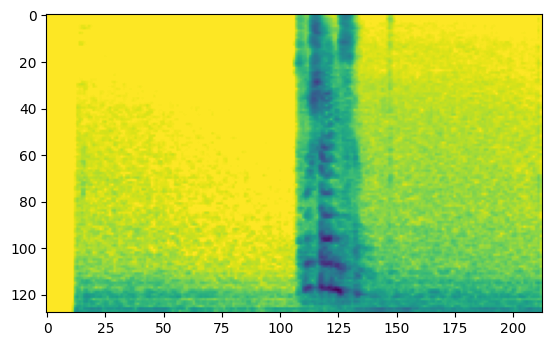

In [7]:
# grayscale transfrom

from PIL import Image
import matplotlib.pyplot as ptl
from src.train.models import get_grscl_transfrom

img = Image.open("data/processed/test_processed/0a2df9e11b2064f934fc30036888166f.png")
ptl.imshow(img)

grsc_png_tr = get_grscl_transfrom()
tr_img = grsc_png_tr(img)


img.mode, tr_img.shape

In [19]:
from mllib.pytorch.utils import get_simple_summary
import torch

model = get_torch_model(params=params, device=device)
get_simple_summary(model)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [24, 3, 100, 100]    [24, 2]              --                   Partial
├─Conv2d (conv1)                         [24, 3, 100, 100]    [24, 64, 50, 50]     (9,408)              False
├─BatchNorm2d (bn1)                      [24, 64, 50, 50]     [24, 64, 50, 50]     (128)                False
├─ReLU (relu)                            [24, 64, 50, 50]     [24, 64, 50, 50]     --                   --
├─MaxPool2d (maxpool)                    [24, 64, 50, 50]     [24, 64, 25, 25]     --                   --
├─Sequential (layer1)                    [24, 64, 25, 25]     [24, 64, 25, 25]     --                   False
│    └─BasicBlock (0)                    [24, 64, 25, 25]     [24, 64, 25, 25]     --                   False
│    │    └─Conv2d (conv1)               [24, 64, 25, 25]     [24, 64, 25, 25]     (36,864)             False
│    │    